# Predicting Elevated Temperatures: A Regression Analysis

__Introduction__

Recent infectious disease outbreaks have led to a surge in the use of infrared thermographs (IRTs) for detecting elevated body temperature in settings such as hospitals, event venues, airports, and other crowded areas. However, these devices have shown to be inconsistent as diagnostic measures due to the variation in device quality and application. 

This project looks at whether using more standardised IRTs will achieve more clinical accuracy in detecting potential disease. 

**Methodology**

This dataset comes from a study conducted by Wang et al. involving over 1000 subjects. In the study, facial temperature data were collected using two different infrared thermographs, as well as two separate oral temperature recordings for each subject. Additionally, the dataset contains demographic details, ambient temperature, and relative humidity, comprising a total of 33 features and 1020 instances.

The goal of this project is to develop a regression model that predicts oral temperature using thermal image readings in combination with subject-specific and environmental information.

**Research Question: Could standardised infrared thermographs accurately predict elevated body temperatures?**

Reference: Wang, Q., Zhou, Y., Ghassemi, P., Chenna, D., Chen, M., Casamento, J., Pfefer, J., & Mcbride, D. (2023). Facial and oral temperature data from a large set of human subject volunteers (version 1.0.0). PhysioNet. https://doi.org/10.13026/3bhc-9065.

In [146]:
# import libraries
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# preprocessing
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.special import inv_boxcox
# metrics 
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
# regression models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# model selection 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [175]:
# fetch dataset 
infrared_thermography_temperature = fetch_ucirepo(id=925) 
  
# load datasets
X = infrared_thermography_temperature.data.features 
y = infrared_thermography_temperature.data.targets 

# make copy of datasets for model building
X_df = X.copy()
y_df = y['aveOralM'].copy()

# show all the columns of the df
pd.set_option('display.max_columns', None)

### Data Exploration

In [7]:
print(X.shape)

(1020, 33)


In [8]:
# variable information 
print(infrared_thermography_temperature.variables) 

           name     role         type demographic  \
0     SubjectID       ID  Categorical        None   
1      aveOralF   Target   Continuous        None   
2      aveOralM   Target   Continuous        None   
3        Gender  Feature  Categorical      Gender   
4           Age  Feature  Categorical         Age   
5     Ethnicity  Feature  Categorical   Ethnicity   
6         T_atm  Feature   Continuous        None   
7      Humidity  Feature   Continuous        None   
8      Distance  Feature   Continuous        None   
9     T_offset1  Feature   Continuous        None   
10    Max1R13_1  Feature   Continuous        None   
11    Max1L13_1  Feature   Continuous        None   
12  aveAllR13_1  Feature   Continuous        None   
13  aveAllL13_1  Feature   Continuous        None   
14        T_RC1  Feature   Continuous        None   
15    T_RC_Dry1  Feature   Continuous        None   
16    T_RC_Wet1  Feature   Continuous        None   
17    T_RC_Max1  Feature   Continuous        N

In [9]:
y.head()

,aveOralF,aveOralM
0,36.85,36.59
1,37.00,37.19
2,37.20,37.34
3,36.85,37.09
4,36.80,37.04


The dataset comes with two target variables which describe the average oral temperature recorded in two operation modes: fast and monitor. As the monitor mode is more accurate than the fast mode, only the monitor mode will be used for my model.

In [10]:
X.head()

,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1
0,Male,41-50,White,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,34.9175,34.9850,34.9850,34.7625,35.0325,35.3375,35.3375,34.4850,35.3775,34.7850,34.4650,35.3775,35.3375,33.5775,33.4775,33.3725,33.4925,33.0025,34.5300,34.0075,35.6925,35.6350,35.6525
1,Female,31-40,Black or African-American,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,34.2250,34.7100,34.6325,34.6400,34.7425,34.5600,34.5375,34.3500,34.5750,34.3225,34.2400,34.7400,34.7150,34.0325,34.0550,33.6775,33.9700,34.0025,34.6825,34.6600,35.1750,35.0925,35.1075
2,Female,21-30,White,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,34.8000,35.6850,35.6675,35.6150,35.7175,35.5025,35.5025,35.2950,35.5300,35.3575,35.0925,35.7175,35.6825,34.9000,34.8275,34.6475,34.8200,34.6700,35.3450,35.2225,35.9125,35.8600,35.8850
3,Female,21-30,Black or African-American,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,35.2475,35.2075,35.2000,35.1175,35.2250,35.5950,35.5950,35.3275,35.6125,34.9100,35.1700,35.6125,35.5950,34.4400,34.4225,34.6550,34.3025,34.9175,35.6025,35.3150,35.7200,34.9650,34.9825
4,Male,18-20,White,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,35.3675,35.6025,35.4750,35.5700,35.6400,35.6400,35.6400,35.0775,35.6675,35.3550,35.1200,35.6650,35.6475,35.0900,35.1600,34.3975,34.6700,33.8275,35.4175,35.3725,35.8950,35.5875,35.6175


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gender       1020 non-null   object 
 1   Age          1020 non-null   object 
 2   Ethnicity    1020 non-null   object 
 3   T_atm        1020 non-null   float64
 4   Humidity     1020 non-null   float64
 5   Distance     1018 non-null   float64
 6   T_offset1    1020 non-null   float64
 7   Max1R13_1    1020 non-null   float64
 8   Max1L13_1    1020 non-null   float64
 9   aveAllR13_1  1020 non-null   float64
 10  aveAllL13_1  1020 non-null   float64
 11  T_RC1        1020 non-null   float64
 12  T_RC_Dry1    1020 non-null   float64
 13  T_RC_Wet1    1020 non-null   float64
 14  T_RC_Max1    1020 non-null   float64
 15  T_LC1        1020 non-null   float64
 16  T_LC_Dry1    1020 non-null   float64
 17  T_LC_Wet1    1020 non-null   float64
 18  T_LC_Max1    1020 non-null   float64
 19  RCC1  

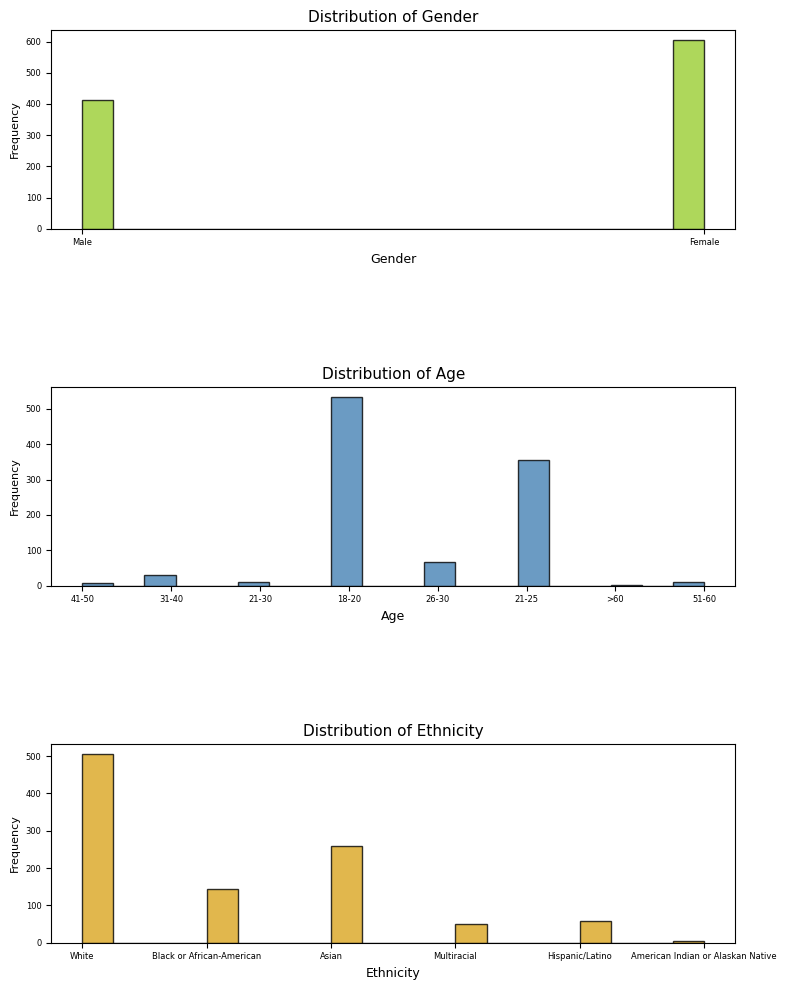

In [12]:
## plot distribution of categorical columns
# select categorical columns 
cat_columns = X.select_dtypes(exclude=['number']).columns

# plot 
num_rows = (len(cat_columns))
fig,axes = plt.subplots(num_rows, 1, figsize=(8, 10)) 
colors = ["yellowgreen", "steelblue", "goldenrod"]

for i, col in enumerate(cat_columns):
    row = i 
    color_choice = colors[i % len(colors)] 
    
    axes[row].hist(X[col], bins=20, edgecolor="black", color = color_choice, alpha=0.8) 
    axes[row].set_title(f"Distribution of {col}", fontsize=11)
    axes[row].set_xlabel(f"{col}", fontsize=9)
    axes[row].set_ylabel("Frequency", fontsize=8)
    axes[row].tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()  
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()

Looking at the distribution of the demographic data, there are slightly more females than males (60% vs. 40%), and a large majority of subjects fall within the 18–25 years age bracket. Over 95% of the subjects are under the age of 30, and half of them are of white descent. Given that this sample does not reflect the broader age distribution of the overall population, the findings should be interpreted with caution when generalising to the general public.

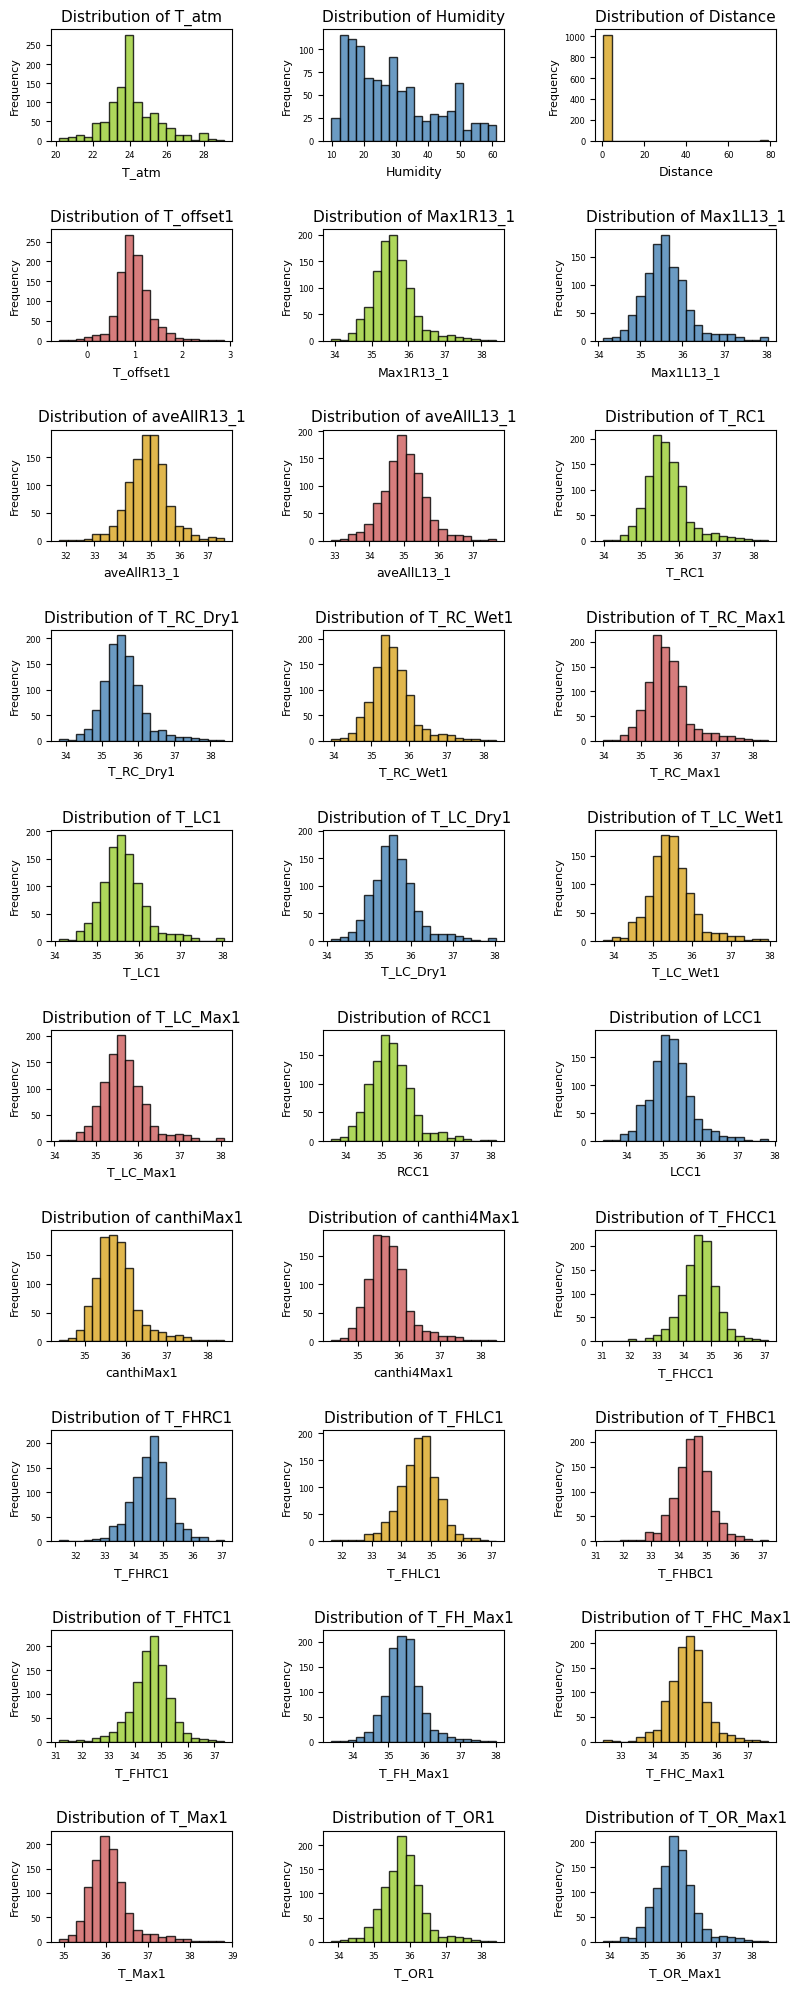

In [13]:
## plot distribution of numerical columns
# select numerical columns 
numeric_columns = X.select_dtypes(include=['number']).columns

# plot 
num_rows = (len(numeric_columns) + 1) // 3
fig,axes = plt.subplots(num_rows, 3, figsize=(8, 20)) 
colors = ["yellowgreen", "steelblue", "goldenrod", "indianred"]

for i, col in enumerate(numeric_columns):
    row = i // 3  
    col_idx = i % 3  
    color_choice = colors[i % len(colors)] 
    
    axes[row, col_idx].hist(X[col], bins=20, edgecolor="black", color = color_choice, alpha=0.8) 
    axes[row, col_idx].set_title(f"Distribution of {col}", fontsize=11)
    axes[row, col_idx].set_xlabel(f"{col}", fontsize=9)
    axes[row, col_idx].set_ylabel("Frequency", fontsize=8)
    axes[row, col_idx].tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()  
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()

Most of the numerical columns exhibit a normal distribution, except for humidity, which is positively skewed, and distance, which has a constant value of 0.8.

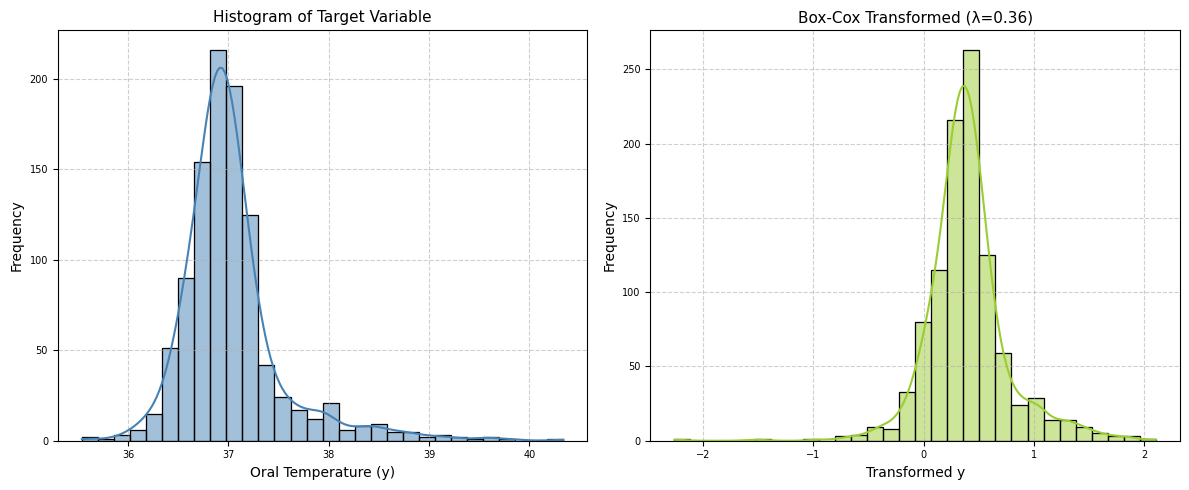

In [14]:
## graph target column 

y_transformed, lambda_best = stats.boxcox(y['aveOralM'] - np.min(y['aveOralM'])+0.01)
# Create figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original Distribution
sns.histplot(y['aveOralM'], kde=True, bins=30, ax=ax[0], color='steelblue')
ax[0].set_title('Histogram of Target Variable', fontsize=11)
ax[0].set_xlabel('Oral Temperature (y)', fontsize=10)
ax[0].set_ylabel('Frequency', fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=7)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Box-Cox Transformed Distribution
sns.histplot(y_transformed, kde=True, bins=30, ax=ax[1], color='yellowgreen')
ax[1].set_title(f'Box-Cox Transformed (λ={lambda_best:.2f})', fontsize=11)
ax[1].set_xlabel('Transformed y', fontsize=10)
ax[1].set_ylabel('Frequency', fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=7)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

A histogram of the target variable shows a slightly right-skewed distribution. Transformation with the Box-Cox helps reduce the skewness and make the distribution closer to normal.

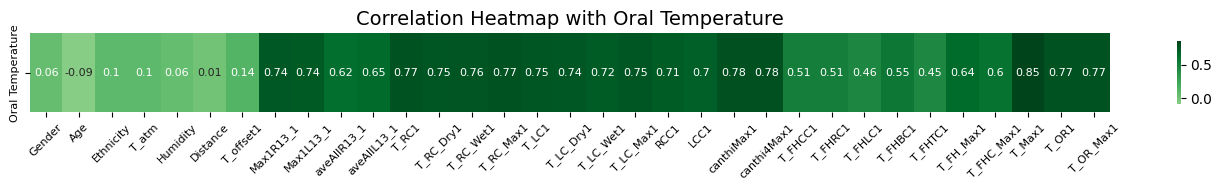

In [15]:
## correlation matrix between predictors and target variable
X = X.assign(aveOralM=y['aveOralM'])
# convert categorical columns to numerical using LabelEncoder
label_encoder = LabelEncoder()
categorical_cols = X.select_dtypes(include=['object'])
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])
    
# plot correlation matrix    
X = X.assign(aveOralM=y['aveOralM'])
corr_mat = X.select_dtypes(include=['number']).corr()
target_col = "aveOralM"
corr_temp = corr_mat[[target_col]].drop(target_col).T
corr_temp.rename(index={'aveOralM': 'Oral Temperature'}, inplace=True)
plt.figure(figsize=(14,2))
sns.heatmap(corr_temp, 
            annot=corr_temp.round(2), 
            annot_kws={"size": 8}, 
            cbar_kws={"shrink": 0.8},
            cmap='Greens',
           center= 0)   
plt.xticks(fontsize=8, rotation = 45) 
plt.yticks(fontsize=8, rotation = 90)  
plt.title("Correlation Heatmap with Oral Temperature", fontsize=14)
plt.tight_layout()

In [16]:
# check for missing values
X.isna().sum()

Gender         0
Age            0
Ethnicity      0
T_atm          0
Humidity       0
Distance       2
T_offset1      0
Max1R13_1      0
Max1L13_1      0
aveAllR13_1    0
aveAllL13_1    0
T_RC1          0
T_RC_Dry1      0
T_RC_Wet1      0
T_RC_Max1      0
T_LC1          0
T_LC_Dry1      0
T_LC_Wet1      0
T_LC_Max1      0
RCC1           0
LCC1           0
canthiMax1     0
canthi4Max1    0
T_FHCC1        0
T_FHRC1        0
T_FHLC1        0
T_FHBC1        0
T_FHTC1        0
T_FH_Max1      0
T_FHC_Max1     0
T_Max1         0
T_OR1          0
T_OR_Max1      0
aveOralM       0
dtype: int64

### Data Preprocessing

In [17]:
X_train.head()

,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1
0,Male,41-50,White,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,34.9175,34.9850,34.9850,34.7625,35.0325,35.3375,35.3375,34.4850,35.3775,34.7850,34.4650,35.3775,35.3375,33.5775,33.4775,33.3725,33.4925,33.0025,34.5300,34.0075,35.6925,35.6350,35.6525
1,Female,31-40,Black or African-American,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,34.2250,34.7100,34.6325,34.6400,34.7425,34.5600,34.5375,34.3500,34.5750,34.3225,34.2400,34.7400,34.7150,34.0325,34.0550,33.6775,33.9700,34.0025,34.6825,34.6600,35.1750,35.0925,35.1075
2,Female,21-30,White,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,34.8000,35.6850,35.6675,35.6150,35.7175,35.5025,35.5025,35.2950,35.5300,35.3575,35.0925,35.7175,35.6825,34.9000,34.8275,34.6475,34.8200,34.6700,35.3450,35.2225,35.9125,35.8600,35.8850
3,Female,21-30,Black or African-American,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,35.2475,35.2075,35.2000,35.1175,35.2250,35.5950,35.5950,35.3275,35.6125,34.9100,35.1700,35.6125,35.5950,34.4400,34.4225,34.6550,34.3025,34.9175,35.6025,35.3150,35.7200,34.9650,34.9825
4,Male,18-20,White,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,35.3675,35.6025,35.4750,35.5700,35.6400,35.6400,35.6400,35.0775,35.6675,35.3550,35.1200,35.6650,35.6475,35.0900,35.1600,34.3975,34.6700,33.8275,35.4175,35.3725,35.8950,35.5875,35.6175


In [123]:
## set up pipeline for processing the data
def data_preprocessor(df):
    # define columns
    ordinal_columns = ['Age'] # for ordinal encoding

    one_hot_columns = ['Gender', 'Ethnicity']      # for one-hot encoding

    numerical_columns = df.select_dtypes(include=['number']).columns # for imputing with median and scaling

    # define the custom order for OrdinalEncoder
    ordinal_encoder = OrdinalEncoder(categories=[
    ["18-20", "21-25", "21-30", "26-30", "31-40", "41-50", "51-60", ">60"], # age
    ])

    # set up pipeline for numerical values
    numerical_pipeline = Pipeline(steps=[
        ('imputer_median', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # set up pipeline for categorical values that need one-hot
    one_hot_pipeline = Pipeline(steps=[
        ('imputer_mode', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder())
    ])

    # set up pipeline for categorical values that need ordinal encoding
    ordinal_pipeline = Pipeline(steps=[
        ('imputer_mode', SimpleImputer(strategy='most_frequent')),
        ('ordinal_encode', ordinal_encoder)
    ])

    # set up the transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_columns), # impute with median and scale numerical values
            ('onehot', one_hot_pipeline, one_hot_columns),   # one-hot encoder
            ('ord', ordinal_pipeline, ordinal_columns) # ordinal encoder
        ])

    return preprocessor

### Model Building

In [127]:
# initiate dictionary for model metrics
if model_metrics is None:
        model_metrics = {}

In [180]:
# define function to train and evaluate the models
def train_and_evaluate_model(model, X_df, y_df, model_metrics=None):

    # split into training/validation and testing sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=24)

    # split training set further into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=24)

    # fit the feature transformation pipeline  on training data
    preprocessor = data_preprocessor(X_train)

    # transform X variables
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    # apply Box-Cox transformation to y
    y_train_processed, lambda_best = stats.boxcox(y_train - np.min(y_train) + 0.01)

    # ensure the model name exists in the dictionary
    model_name = model.__class__.__name__
    if model_name not in model_metrics:
        model_metrics[model_name] = {}
    print(f"Model: {model.__class__.__name__}")
        
    # training the model
    model.fit(X_train_processed, y_train_processed)

    # predict on validation and test sets
    y_val_pred = model.predict(X_val_processed)
    y_test_pred = model.predict(X_test_processed)

    # reverse y values from Box-Cox transformation 
    y_val_pred_orig = inv_boxcox(y_val_pred, lambda_best) + np.min(y_train) - 0.01
    y_test_pred_orig = inv_boxcox(y_test_pred , lambda_best) + np.min(y_train) - 0.01

    # compute metrics for validation and test set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_orig))
    val_r2 = r2_score(y_val, y_val_pred_orig)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_orig))
    test_r2 = r2_score(y_test, y_test_pred_orig)

    # compute bias
    val_bias = np.mean(y_val_pred_orig - y_val)
    test_bias = np.mean(y_test_pred_orig - y_test)

    # print results
    print(f"Validation RMSE: {val_rmse}, R²: {val_r2}, Bias: {val_bias}")
    print(f"Test RMSE: {test_rmse}, R²: {test_r2}, Bias: {test_bias}")

    # return metrics and model name as a dictionary
    model_metrics[model_name].update({
        "validation": {"RMSE": val_rmse, "R²": val_r2, "Bias": val_bias},
        "test": {"RMSE": test_rmse, "R²": test_r2,  "Bias": test_bias},
    })

    return y_test_pred_orig, y_test_orig, model_metrics

#### Linear Regression

In [182]:
linear_model = LinearRegression()

# train and evaluate
y_test_pred_lr, y_test_lr, model_metrics = train_and_evaluate_model(
    model=linear_model,
    X_df=X_df,
    y_df=y_df,
    model_metrics=model_metrics
)

Model: LinearRegression
Validation RMSE: 0.23828835123073872, R²: 0.744006035173471, Bias: -0.01071166284772621
Test RMSE: 0.24945396132330383, R²: 0.7890502345814536, Bias: -0.01607000228809356


#### RidgeCV Regression

In [183]:
# initiate ridgecv 
ridge_model = RidgeCV()

# train and evaluate
y_test_pred_ridge, y_test_ridge, model_metrics = train_and_evaluate_model(
    model=ridge_model,
    X_df=X_df,
    y_df=y_df,
    model_metrics=model_metrics
)

Model: RidgeCV
Validation RMSE: 0.23064658651193845, R²: 0.760161905365981, Bias: -0.013322055569267586
Test RMSE: 0.24228839041924013, R²: 0.8009952481822924, Bias: -0.021113337554223906


In [184]:
print("Optimal Alpha for RidgeCV:", ridge_model.alpha_)

Optimal Alpha for RidgeCV: 10.0


The optimal alpha for RidgeCV is 10.0, indicating a moderate level of regularization applied to the model. Ridge regression reduces the magnitude of coefficients evenly to prevent overfitting. The validation and test RSME and R^2 values are relatively close, indicating that the model is not significantly overfitting.

#### LassoCV Regression

In [186]:
# initiate lasso regression
lasso_model = LassoCV(max_iter=5000, cv=5)

# train and evaluate
y_test_pred_lasso, y_test_lasso, model_metrics = train_and_evaluate_model(
    model=lasso_model,
    X_df=X_df,
    y_df=y_df,
    model_metrics=model_metrics
)

Model: LassoCV
Validation RMSE: 0.23252991833278458, R²: 0.7562291451520058, Bias: -0.017993762237681565
Test RMSE: 0.24043282626200388, R²: 0.8040317294014719, Bias: -0.01988064107964198


In [187]:
print("Optimal Alpha for LassoCV:", lasso_model.alpha_)

Optimal Alpha for LassoCV: 0.0018390342136328087


The optimal alpha for LassoCV is very low, indicating that minimal regularisation has been applied.

#### ElasticNetCV

In [188]:
# initiate elasticnet regressor
elastic_model = ElasticNetCV(max_iter=1000, cv=5)

# train and evaluate
y_test_pred_elastic, y_test_elastic, model_metrics = train_and_evaluate_model(
    model=elastic_model,
    X_df=X_df,
    y_df=y_df,
    model_metrics=model_metrics
)

Model: ElasticNetCV
Validation RMSE: 0.23240153198940003, R²: 0.7564982564041356, Bias: -0.01815219740134423
Test RMSE: 0.2405438843431587, R²: 0.8038506485823547, Bias: -0.020096307967925567


In [189]:
print("Best L1 ratio:", elastic_model.l1_ratio_)

Best L1 ratio: 0.5


The optimal L1 ratio for the ElasticNetCV model was 0.5, indicating an equal balance between Ridge (L2) and Lasso (L1) regularization. A comparison of test RMSE values shows that Ridge regression performed best (0.2147), outperforming both Lasso and ElasticNet. However, since Lasso regression achieved a better validation RMSE, it contributed equally to the final ElasticNet model.

#### LGBMRegressor with Hyperparameter Tuning

In [201]:
%%capture 
## hyperparameter tuning
# inititate LGBMRegressor
lgbm = LGBMRegressor()

# define hyperparameters 
param_grid = {
    'num_leaves': np.arange(10, 100, 10),  # tree complexity
    'min_child_samples': np.arange(5, 50, 5),  # minimum amount of leaves on node
    'lambda_l1': np.logspace(-3, 1, 5),  # l1 regularization (Lasso) with log changes
    'lambda_l2': np.logspace(-3, 1, 5),  # l2 regularization (Ridge) with log changes
    'learning_rate': np.logspace(-3, 0, 5),  
    'max_depth': [3, 5, 7, 9, -1],  # tree depth
    'subsample': np.linspace(0.6, 1.0, 5)  # fraction of data used per tree
}

# define randomised search with cross validation
random_search = RandomizedSearchCV(
    lgbm, 
    param_distributions=param_grid, 
    n_iter=30,  
    scoring="neg_mean_squared_error",  
    cv=5,  
    verbose=1,
    n_jobs=1,
    random_state=24
)

# split into training/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=24)
categorical_cols = X_train_val.select_dtypes(include=['object']).columns
X_train_val[categorical_cols] = X_train_val[categorical_cols].astype('category')

# fit search to data
random_search.fit(X_train_val, y_train_val) 

# get the best hyperparameters
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

# print the best hyperparameters and corresponding RMSE
print("Best Hyperparameters:", best_params)
print("Best RMSE:", best_rmse)

In [208]:
# LGBMRegressor with the best hyperparameters
LGBM_model_tuned = LGBMRegressor(min_child_samples=5, 
                                 force_col_wise=True,
                                 lambda_l1=0.01,
                                 lambda_l2=0.01,
                                 subsample=0.6,
                                 num_leaves=50,
                                 max_depth=3,
                                 learning_rate=0.0316
                                )

# train and evaluate
y_test_pred_lgbm, y_test_lgbm, model_metrics = train_and_evaluate_model(
    model=LGBM_model_tuned,
    X_df=X_df,
    y_df=y_df,
    model_metrics=model_metrics
)

Model: LGBMRegressor
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Info] Total Bins 6054
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 38
[LightGBM] [Info] Start training from score 0.401675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

#### Random Forest Regressor

In [200]:
# initiate random forest regressor
forest_model = RandomForestRegressor(random_state=24)

# define hyperparameters
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # number of trees
    'max_depth': [None, 10, 20, 30],  # maximum tree depth
    'min_samples_split': [2, 5, 10],  # min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],  # min samples per leaf
    'max_features': [None, 'log2', 'sqrt'],  # number of features considered per split
    'bootstrap': [True, False]  # consider using bootstrap samples
}

# perform random search
random_search = RandomizedSearchCV(
    forest_model, param_distributions=param_dist, 
    n_iter=30, cv=5, scoring='neg_root_mean_squared_error', 
    verbose=1, n_jobs=1, random_state=24
)

# split into training/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=24)

# identify categorical columns
categorical_cols = X_train_val.select_dtypes(include=['object']).columns

# one hot encode categorical columns
X_train_val = pd.get_dummies(X_train_val, columns=categorical_cols, drop_first=True)

# fit random search to data
random_search.fit(X_train_val, y_train_val)

# show the best parameters
print("Best Parameters for Random Forest Regressor:", random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for Random Forest Regressor: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 30, 'bootstrap': True}


In [202]:
# random forest regressor with hyperparameters tuned
forest_model_tuned = RandomForestRegressor(random_state=24,
                                           n_estimators=200,
                                           min_samples_split=10,
                                           min_samples_leaf=4,
                                           max_features=None,
                                           max_depth=30,
                                           bootstrap=True
                                          )

# train and evaluate
y_test_pred_forest, y_test_forest, model_metrics = train_and_evaluate_model(
    model=forest_model_tuned,
    X_df=X_df,
    y_df=y_df,
    model_metrics=model_metrics
)

Model: RandomForestRegressor
Validation RMSE: 0.2311104182286681, R²: 0.7591963036325198, Bias: -0.02000143809258525
Test RMSE: 0.24606068567233289, R²: 0.7947502216984812, Bias: -0.013696867214468054


In [203]:
# show dictionary of model metrics
model_metrics

{'LinearRegression': {'cross validation': 0.3068774149740061,
  'validation': {'RMSE': 0.23828835123073872,
   'R²': 0.744006035173471,
   'Bias': -0.01071166284772621},
  'test': {'RMSE': 0.24945396132330383,
   'R²': 0.7890502345814536,
   'Bias': -0.01607000228809356}},
 'RidgeCV': {'validation': {'RMSE': 0.23064658651193845,
   'R²': 0.760161905365981,
   'Bias': -0.013322055569267586},
  'test': {'RMSE': 0.24228839041924013,
   'R²': 0.8009952481822924,
   'Bias': -0.021113337554223906}},
 'LassoCV': {'validation': {'RMSE': 0.23252991833278458,
   'R²': 0.7562291451520058,
   'Bias': -0.017993762237681565},
  'test': {'RMSE': 0.24043282626200388,
   'R²': 0.8040317294014719,
   'Bias': -0.01988064107964198}},
 'ElasticNetCV': {'validation': {'RMSE': 0.23240153198940003,
   'R²': 0.7564982564041356,
   'Bias': -0.01815219740134423},
  'test': {'RMSE': 0.2405438843431587,
   'R²': 0.8038506485823547,
   'Bias': -0.020096307967925567}},
 'LGBMRegressor': {'validation': {'RMSE': 0.235

### Results

In [204]:
# define function to plot scatterplot of actual vs predicted temperatures
def plot_scatter(model_name, y_test_orig, y_test_pred_orig):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_orig, y_test_pred_orig, alpha=0.5)
    plt.plot([min(y_test_orig), max(y_test_orig)], [min(y_test_orig), max(y_test_orig)], 'indianred', linestyle='dashed')
    plt.xlabel("Actual Temperature")
    plt.ylabel("Predicted Temperature")
    plt.title(f"Actual vs. Predicted Temperatures for Best Model: {model_name}")
    plt.show()

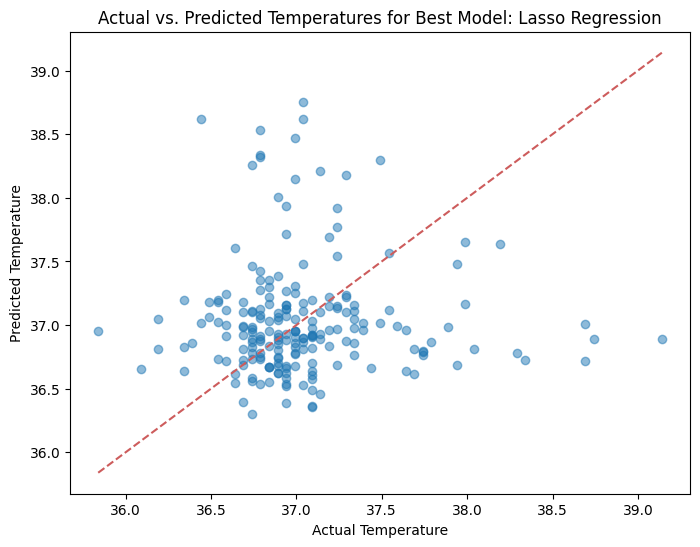

In [206]:
# visualise scatter plot for actual vs predicted values
plot_scatter(
    model_name = "Lasso Regression",
    y_test_orig = y_test_lasso,
    y_test_pred_orig = y_test_pred_lasso
)

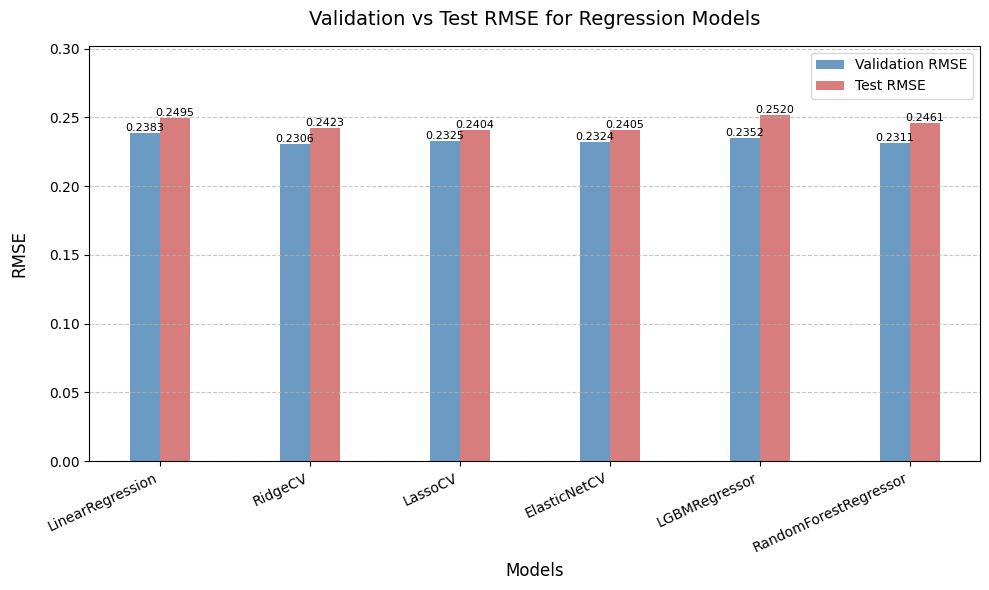

In [205]:
## plot validation vs test RMSE for models
# extract model names from dictionary
models = list(model_metrics.keys())

# extract RMSE values from dictionary
validation_rmse = [model_metrics[m]["validation"]["RMSE"] for m in models]
test_rmse = [model_metrics[m]["test"]["RMSE"] for m in models]

# Set bar width
bar_width = 0.2
x = np.arange(len(models))  # the label locations

# create bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - bar_width/2, validation_rmse, bar_width, label='Validation RMSE', color='steelblue', alpha=0.8)
bars2 = plt.bar(x + bar_width/2, test_rmse, bar_width, label='Test RMSE', color='indianred', alpha=0.8)
# add value for bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.4f}', 
             ha='center', va='bottom', fontsize=8)

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.4f}', 
             ha='center', va='bottom', fontsize=8)

plt.xlabel("Models", size=12, labelpad=5)
plt.ylabel("RMSE", size=12, labelpad=15)
plt.ylim(0, max(max(validation_rmse), max(test_rmse)) + 0.05)
plt.title("Validation vs Test RMSE for Regression Models", size=14, pad=15)
plt.xticks(ticks=x, labels=models, rotation=25, ha="right")
plt.legend(loc='upper right',bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Conclusion

The best-performing model was LassoCV (0.2404 test RMSE), showing a slight improvement over Linear Regression (0.2495 test RMSE), RidgeCV (0.2434 test RMSE), and ElasticNetCV (0.2405 test RMSE). LGBMRegressor (0.2520 test RMSE) and RandomForestRegressor (0.2461 test RMSE) performed slightly worse than the linear regression based models, indicating that the dataset exhibited a predominantly linear relationship. The data structure may not have provided meaningful nonlinear patterns through the hierarchical splits and decision boundaries that the tree-based models implemented.

All the models exhibited lower validation RMSEs compared to test RMSEs, indicating a degree of overfitting. Further optimisations which could help finetune the models could include feature selection or PCA to mitigate overfitting by ensuring the models only capture the most relevant information. 

Overall, the infrared thermography data successfully predicted body temperature with an error of 0.24 degrees, demonstrating its potential for detecting elevated body temperatures. With a standardised setup, infrared thermography could be a valuable tool for accurately detecting elevated body temperatures and assessing potential infections in real-world applications.